# Programming Machine Learning Lab
# Exercise 12

**General Instructions:**

1. You need to submit the PDF as well as the filled notebook file.
1. Name your submissions by prefixing your matriculation number to the filename. Example, if your MR is 12345 then rename the files as **"12345_Exercise_12.xxx"**
1. Complete all your tasks and then do a clean run before generating the final PDF. (_Clear All Ouputs_ and _Run All_ commands in Jupyter notebook)

**Exercise Specific instructions::**

1. You are allowed to use only NumPy and Pandas (unless stated otherwise). You can use any library for visualizations.

In [22]:
#Import Libraries

import numpy as np
import pandas as pd
from scipy.spatial.distance import euclidean
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import time
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
warnings.filterwarnings('ignore')

### Part 1

**K-Means** 

K-Means algorithm splits a dataset $X \in \{x_1, \dots, x_N\}$ into $K$ many partitions, where each $X_k \subseteq X \quad \forall k \in \{1, \dots, K\}$. Clustering algorithms like the *K-Means* is a useful technique when the true labels are unknown. Or in other words, we are basically interested in analyzing patterns within the data and make useful inferences.    

In this task, you will implement a *K-Means* algorithm from scratch using the dataset **"HTRU_2.csv"**. The dataset contains 8 continuous variables describing a pulsar candidate (https://archive.ics.uci.edu/ml/datasets/HTRU2). The task is to identify ($K$) clusters that might best describe the classes within the data. 


The basic algorithm is given by:

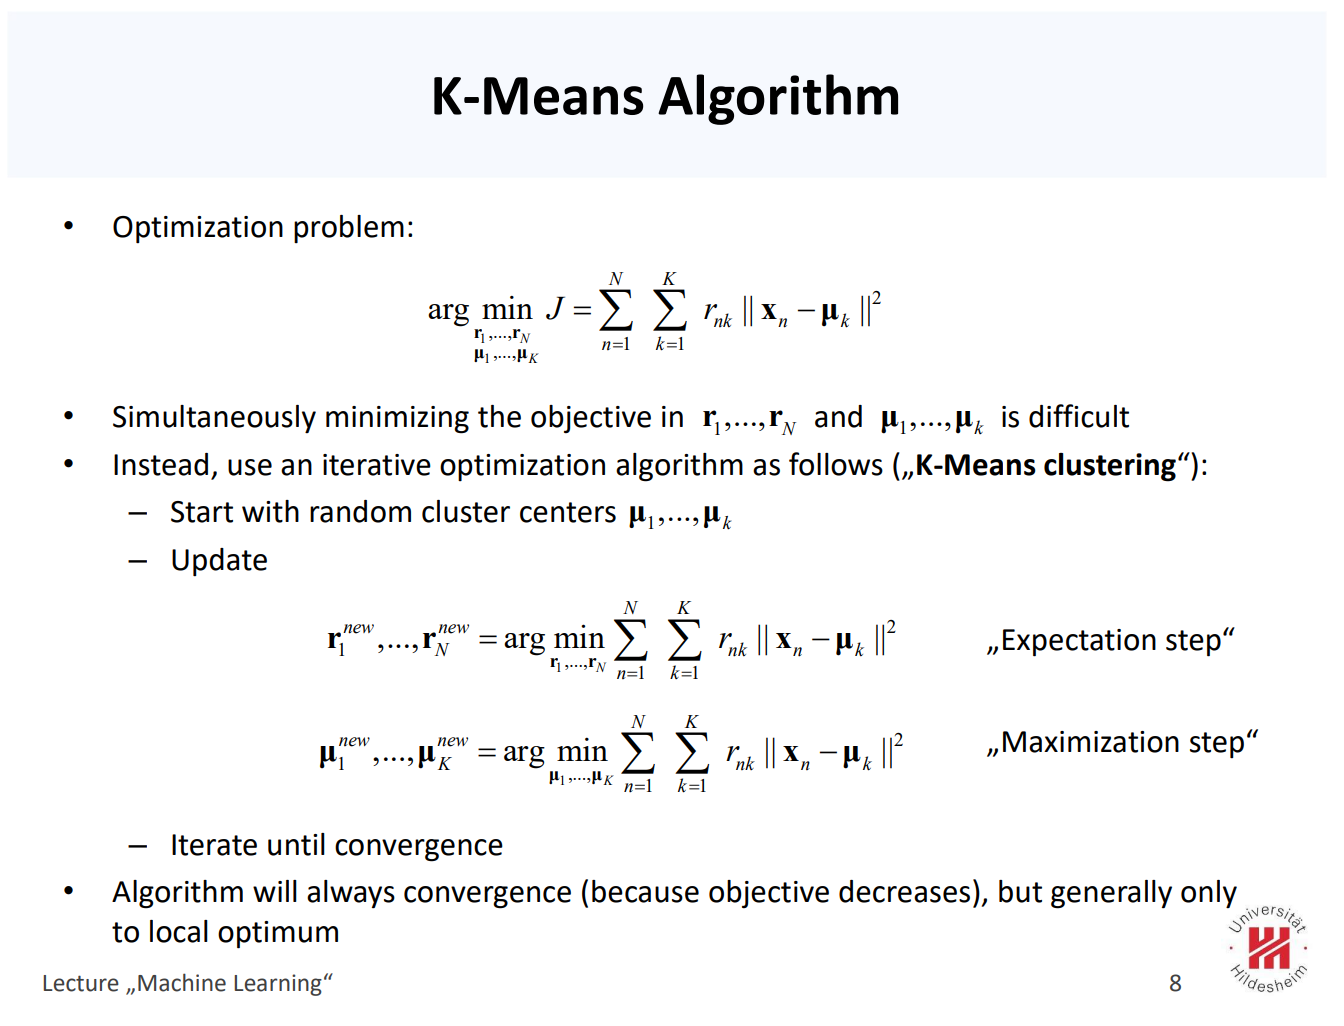

In [2]:
##upda
class KMeansClustering:
    def __init__ (self, n_iters, tol=1e-3, max_k=6):
        self.n_iters = n_iters #number of random initializations
        self.tol = tol #tolerance for stopping criteria
        self.max_k = max_k #maximum k value to be checked for elbow test
        
    def initialize_centers(self, X, k):
        centers = [] #list to store all initial cluster centers
        
        i = np.random.randint(len(X)) #first point is picked at random
        centers.append(X[i,:]) #append first point in the list
        
        while len(centers) < k: #iterate till we have K cluster centers

            farthest_dist = -np.inf #initialize it with large negative number
            farthest_pt = None #to track the index of farthest point

            for idx,x in enumerate(X): #iterate over each observation
                c_dist = [] #list to store the distance of each observation from cluster centers

                for c in centers: #iterate over each center
                    c_dist.append(euclidean(c,x)**2) #calculate distance of the centers from the point and append in list

                #once we have distances from all the centers we need to sum them up
                added_dist = np.sum(c_dist)

                #to check if the point is farthest as compared to rest of the points
                if added_dist > farthest_dist:
                    farthest_dist = added_dist #to track the distance itself
                    farthest_pt = idx #to track the index

            #add the farthest point as new cluster center       
            centers.append(X[farthest_pt,:])
            
        return centers
            
    def find_associations(self, X, centers):
        associations = [] #list to store association of each point with the clusters
        for x in X: #iterate over each example
            c_dist = [] #list to store distance of point from each cluster center
            for c in centers: #iterate over each cluster center
                c_dist.append(euclidean(c,x)**2) #calculate distance of the centers from the point and append in list
            #once we have distances from all the centers we need to find the minimum one and append in list
            associations.append(np.argmin(c_dist))
        return associations
            
    def compute_cluster_center(self, X, associations, k):
        cls = np.arange(k) #number of clusters
        centers = [] #list to store the new cluster centers
        for cl in cls: #iterate for each class 
            idx = np.array(associations) == cl #find the index of all instances which belong to particular cluster
            centers.append(X[idx,:].mean(axis=0)) #to find the mean of all the instances, this will be the new cluster center
        return centers
                
    def check_stop(self, old, new, k):
        d = 0 #to store the sum of differences between the old and new means
        for ki in range(k): #for all the clusters
            #check the euclidean distance between the old and new means and add them for each cluster
            d += euclidean(old[ki],new[ki])
        return d/k
    
    def calculate_distortions(self, X, associations, centers):
        distortion = 0 #to track the distortion of the model
        for i,c in enumerate(centers): #first calculate the distortion of each example from its respective cluster
            idx = np.array(associations) == i #find the index of all instances which belong to particular cluster
            X_subset = X[idx] #find the subset of data
            c_distortion = 0 #to track distortion within each cluster
            for x in X_subset: #iterate over the subset of data
                c_distortion += euclidean(centers[i],x)**2 #find the distance of each point from its center
            #once we have cluster wise distortion, add them up
            distortion += c_distortion
        return distortion   
    
    def find_optimal_k(self, X, centers, silhouette=False):
        distort_lst = [] #list to store distortion for each value of k
        centers_lst = [] #to store the centers
        self.silhouette_avg_history = []
        for k in range(1, self.max_k + 1): #iterate over all ks
            #fit the Kmeans for each k
            c = self.fit_once(X, centers, k)
            centers_lst.append(c) #to store centers associated with each K value
            P = self.find_associations(X, c)
            
            if silhouette:
                # Calculate and print the silhouette score for the optimal clustering
                silhouette_avg = self.calculate_silhouette_score(X, P, c)
                self.silhouette_avg_history.append(silhouette_avg)
#                 print(f"Silhouette Score for {k} Cluster: {silhouette_avg}")
                
            else:
                #now find the distortion
                distort = self.calculate_distortions(X, P, c)
                #store the value of distortion for current value of k
                distort_lst.append(distort)

        if silhouette:
            optimal_k = np.argmax(self.silhouette_avg_history) + 1
            best_centers = centers_lst[optimal_k]
            return optimal_k, self.silhouette_avg_history, best_centers
        
        else:
            diff = np.diff(distort_lst) #to find difference of each distortion
            diff_r = diff[1:] / diff[:-1] #take the ratio
            optimal_k = np.argmax(diff_r) + 1 #find the most drastic change
            best_centers = centers_lst[optimal_k] #get the center associated with optimal k
            self.distort_lst = distort_lst
            return optimal_k, distort_lst, best_centers

    def calculate_silhouette_score(self, X, associations, centers):
        n = len(X)
        s_values = []

        for i in range(n):
            # Calculate average distance of the current point to other points in the same cluster
            a_i = np.mean([euclidean(X[i], X[j]) for j in range(n) if associations[j] == associations[i] and j != i])

            # Calculate average distance of the current point to points in the nearest neighboring cluster
            b_i_values = []
            for k in range(self.max_k):
                if k != associations[i]:
                    b_i_values.append(np.mean([euclidean(X[i], X[j]) for j in range(n) if associations[j] == k]))

            b_i = min(b_i_values) if b_i_values else 0

            # Calculate silhouette score for the current point
            s_i = (b_i - a_i) / max(a_i, b_i) if max(a_i, b_i) != 0 else 0
            s_values.append(s_i)

        # Calculate average silhouette score for all points
        silhouette_avg = np.mean(s_values)
        return silhouette_avg
    
    def plot_silhouette_scores(self, X, centers, init_count):
        max_k = self.max_k
        best_k, silhouette_scores, _ = self.find_optimal_k(X, centers, silhouette=True)
        # Plot silhouette scores for different values of k
        plt.plot(range(1, max_k + 1), silhouette_scores, marker='o')
        plt.plot(best_k+1,silhouette_scores[best_k], marker="o", markersize=10, markerfacecolor="red",label='Best Cluster')
        plt.title(f'Silhouette Scores for Different Values of K for initialization {init_count}')
        plt.xlabel('Number of clusters (K)')
        plt.legend()
        plt.ylabel('Silhouette Score')
        plt.show()
    
    def plot_elbow(self, X, centers, init_count):
        best_k, d_list, _ = self.find_optimal_k(X, centers) #find the best number of clusters
        plt.plot(np.arange(1, self.max_k +1),d_list) #plot the num cluster against distortion
        #highlight best number of cluster
        plt.plot(best_k,d_list[best_k-1], marker="o", markersize=10, markerfacecolor="red",label='Best Cluster')
        #formatiing the plot
        plt.title(f'Best Number of Cluster for initialization {init_count}')
        plt.xlabel('Number of clusters')
        plt.legend()
        plt.ylabel('Distortion')
        plt.show()

    def fit_once(self, X, centers, k):
        while True: #this keeps the loop running until the stopping criteria has been met
            if self.elbow_plot == True:
                centers = centers[:k]
            elif self.silhouette_plot:
                centers = centers[:k]
            #to find the association of each observation with cluster
            P = self.find_associations(X,centers)
            #to find the means of our clusters
            new_centers = self.compute_cluster_center(X, P, k)
            #to avoid cluster with 0 elements
            empty_cls= len(np.unique(P)) == k #check if we have empty cluster
            #if we catch an empty cluster
            if not empty_cls is True:
                #to find which cluster has zero members
                ec = [k for k in np.arange(k) if not k in np.unique(P)]
                #iterte over all such empty clusters
                for e in ec:
                    new_centers[e] = centers[e] #do not change their cluster mean

            #to check the stopping criteria
            err = self.check_stop(centers, new_centers, k)
            #replace old centers with new ones for next iteration
            centers = new_centers
            #stop the process once the value is lower than tolerance
            if err < self.tol:
                self.optimial_centers = new_centers #store the optimal centers
                return self.optimial_centers
    
    def fit(self, X, k=3, find_k=False):
        low_distort = np.inf #store the smallest distortion
        self.elbow_plot = True if find_k=='elbow' else False
        self.silhouette_plot = True if find_k=='silhouette' else False
        for i in range(1,self.n_iters+1): #do random initialization bunch of times
            centers = self.initialize_centers(X, self.max_k) #this initializes all the centers at once
            #to check if we do not want to plot best number of cluster for each initialization
            if find_k is False:
                centers = centers[:k] #only obtain first k clusters
                oc = self.fit_once(X, centers, k) #fitting the model
            elif find_k == 'elbow':
                self.plot_elbow(X, centers, i) #this prints the plot of cluster for each initialization
            elif find_k == 'silhouette':
                self.plot_silhouette_scores(X, centers, i)
                
            #now it's time to find the distortion of our optimal model
            P = self.find_associations(X,self.optimial_centers)
            distort = self.calculate_distortions(X, P, self.optimial_centers)
            #check if the distortion is minimal
            if distort < low_distort:
                low_distort = distort #replace the lowest with current distortion
                self.distort = distort
                self.centers = self.optimial_centers #store the optimal centers in class variable
                
    def predict(self, X):
        return self.find_associations(X,self.centers) #it is analogus to step of finding the association

In [3]:
df = pd.read_csv('HTRU_2.csv')

#Since the features are not standardized, we need to standardize them
X = StandardScaler().fit_transform(df)

Here our algorithm is capable of selecting first center as random and then rest with the maximum distance from cluster centers sequentially. Also we will run our algorithm for 5 random initializations.

In [4]:
KMClustering = KMeansClustering(n_iters=5)

**Evaluation**

Since K-means is an unsupervised approach, we need to find a method of finding out the best $K$ for the task. There are multiple methods of determining the ideal K for a given dataset. Read up and implement atleast one of these methods from scratch:
1. Elbow 
1. Average silhouette method
1. Gap statistic method

- Create a visualization to show the statistics for the selected method vs different number of clusters $K$. Comment on how the best *K* is found using the method of your choice.

*In case you did not do the first part of this question, you can use sklearn implementation of KMeans clustering for this. You can also implement any other method that you find to determine the optimal K*

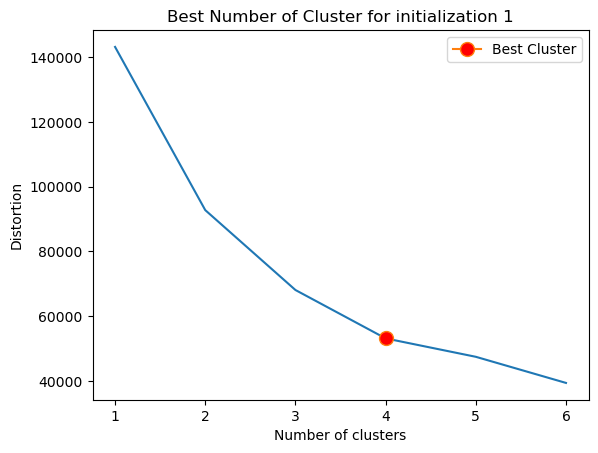

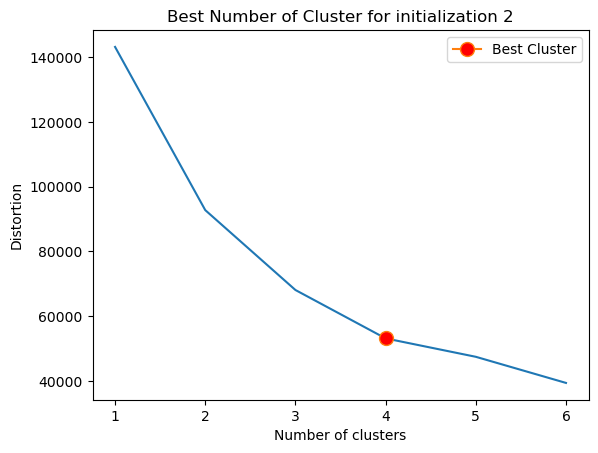

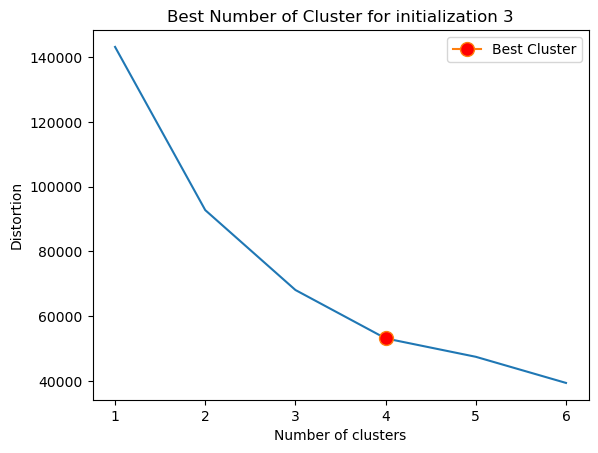

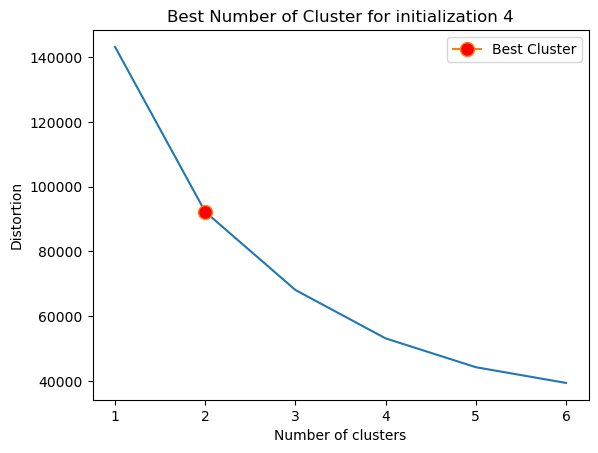

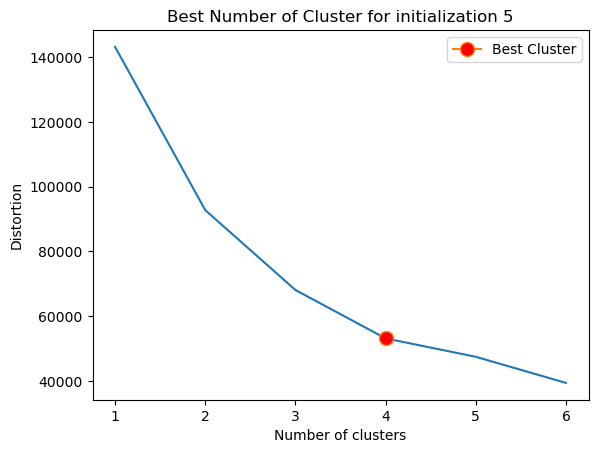

In [5]:
### Write your code here
KMClustering.fit(X, k=5, find_k='elbow')

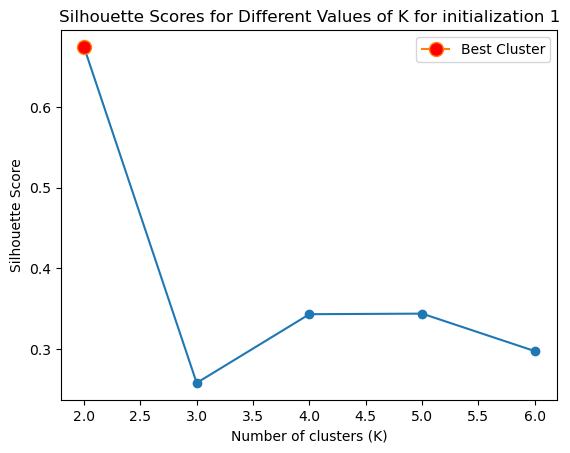

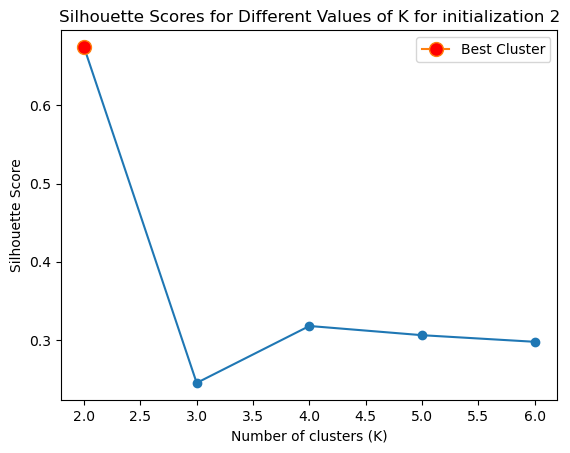

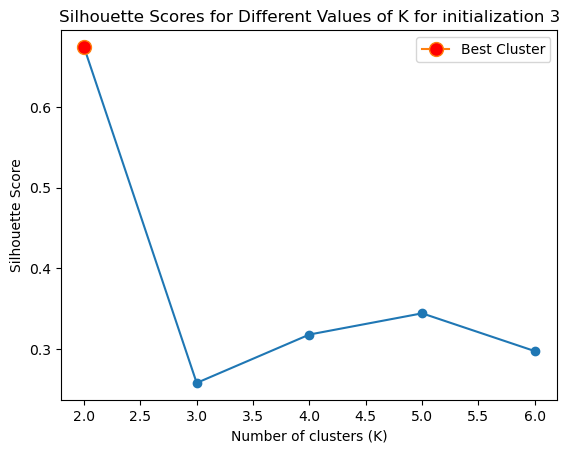

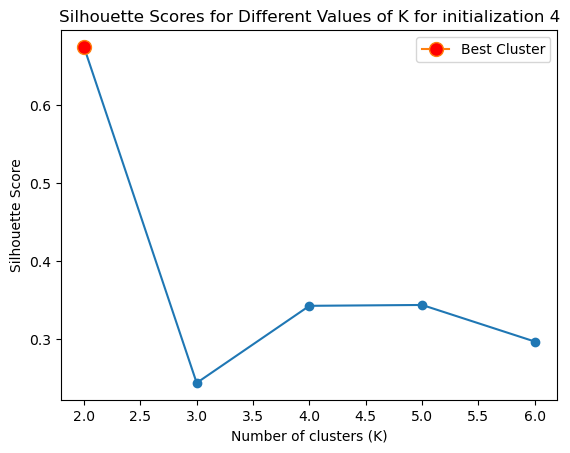

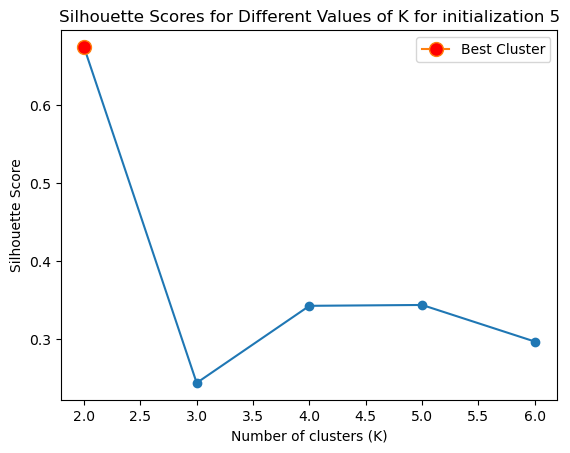

In [7]:
#to save time we will run on 1000 instances only
KMClustering.fit(X[:1000,:], k=5, find_k='silhouette')

**Note:** Here, we see that Silhouette method tells us that optimal clusters should be 2 but elbow method tells us that 4 is the optimal size. We can choose any number of cluster between 2 and 4 in this case.

**Visualization**

- Principal Components Analysis (PCA) is a widely used method for reducing the number of dimensions to a low dimensional representation of the data. Create a function that performs PCA on the given dataset. (You are allowed to use numpy.linalg.svd for single value decomposition).
- Use (PCA) to reduce the dimensionality of the data and represent the clusters (K-means) as both 2D and 3D visualizations. 

*In case you did not do the first part of this question, you can use sklearn implementation of KMeans clustering for this.*

In [16]:
### Write youir code here
class DimensionalityReduction:
    def __init__ (self, n_components):
        self.n_components = n_components #the number of dimensions we want to represent our data
        
    def transform(self, X, mode):
        #first perform mean centering of the data
        X_centered = X - np.mean(X , axis = 0)
        
        #using SVD method
        if mode == 'svd':
            u,s,v = np.linalg.svd(X_centered) #perform the singular value decomposition
            m,n = X.shape #to find the dimensions of our data
            #to create a matrix of singular values of same dimensions as that of X
            S = np.zeros(X_centered.shape)
            S[:n,:n] = np.diag(s) #enter the sigular values on diagonal
            S_reduced = S[:,:self.n_components] #only take the singular values till the dimension we want to reduce
            X_reduced = np.matmul(u,S_reduced) #reduce the dimensions
        
        #using PCA method
        elif mode == 'pca':
            #find the covariance matric of same dimension
            cov_matrix = np.cov(X_centered , rowvar = False)
            #to get the eigen values and eigen vectos of covariance matrix
            eigh_vals , eigh_vecs = np.linalg.eigh(cov_matrix)
            #sort by maximum to minimum eigen value
            sorted_idx = np.argsort(eigh_vals)[::-1] #argsort sort ascendingly we want in descending fashion therefore inverting
            sorted_eighvals = eigh_vals[sorted_idx] #from index get the values themselves
            sorted_eighvecs = eigh_vecs[:,sorted_idx] #from index get the vector themselves
            #reduce the eigenvector
            reduced_eighvecs = sorted_eighvecs[:,:self.n_components]
            #performing PCA
            X_reduced = (reduced_eighvecs.T @ X_centered.T).T
        
        return X_reduced

In [17]:
#Let's reduce the dimension of our data to 2-d
pca_analysis = DimensionalityReduction(n_components=2)
X_red = pca_analysis.transform(X,'pca')
#compare with Sklearn
pca_sklearn = PCA(n_components=2).fit_transform(X)

In [18]:
#to rotate the axis of our data
X_red[:,1] = X_red[:,1]*-1

np.allclose(X_red, pca_sklearn)

True

**Conclusion:** The numpy in-built function which compares two arrays returns True which means that the reduced representation in our's and sklearn's case is same.

In [19]:
km = KMeans(n_clusters=4)
km.fit(X_red)
labels = km.predict(X_red)

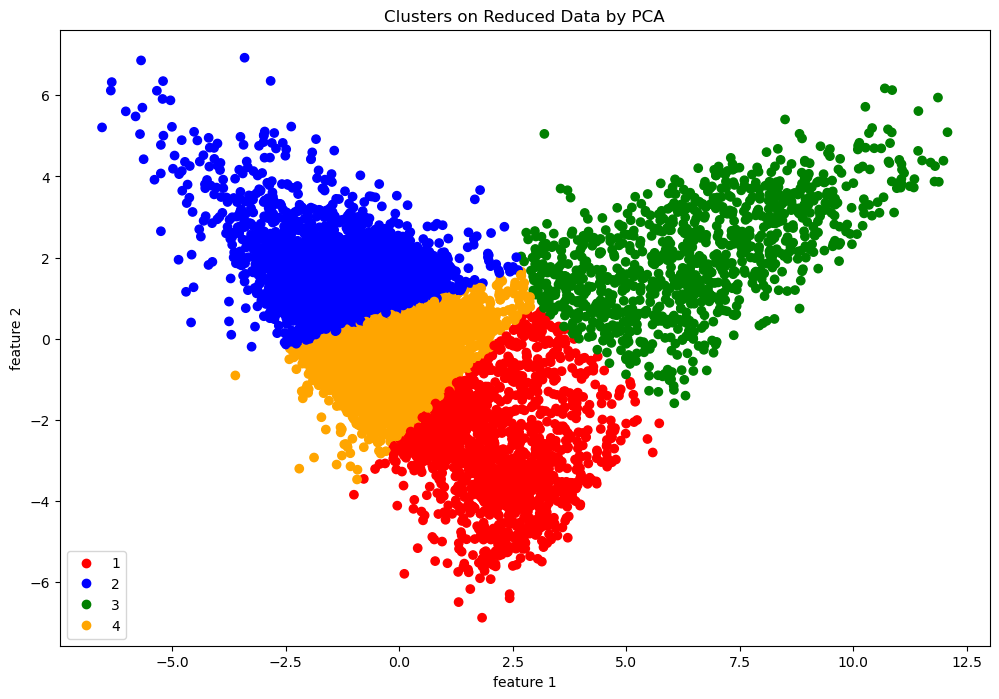

In [21]:
# To plot clusters
plt.figure(figsize=(12,8))
classes = ['1', '2', '3', '4']
colors = ListedColormap(['r','b','g','orange'])
scatter = plt.scatter(X_red[:,0],X_red[:,1],c=labels, cmap=colors)
plt.legend(handles=scatter.legend_elements()[0], labels=classes);
plt.title('Clusters on Reduced Data by PCA');
plt.xlabel('feature 1');
plt.ylabel('feature 2');

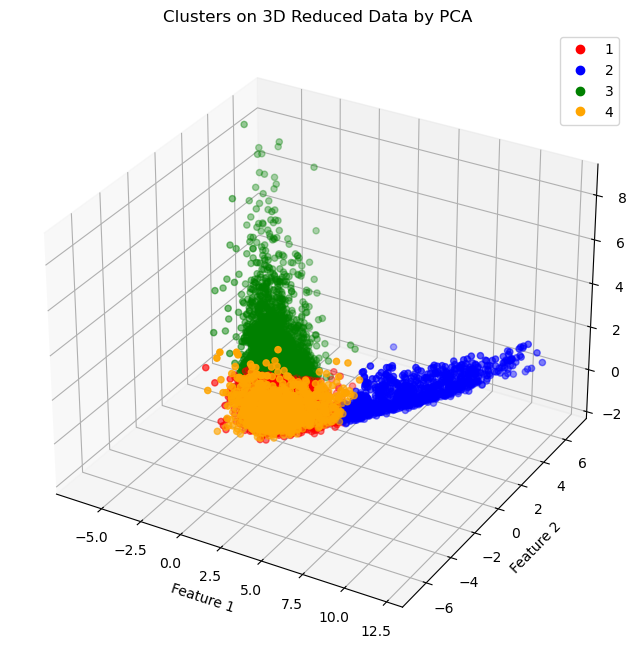

In [23]:
#3D Plot
pca_sklearn = PCA(n_components=3).fit_transform(X)

# Fit KMeans on the PCA-transformed data
km = KMeans(n_clusters=4)
km.fit(pca_sklearn)
labels = km.predict(pca_sklearn)

# To plot clusters in 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

classes = ['1', '2', '3', '4']
colors = ListedColormap(['r', 'b', 'g', 'orange'])

scatter = ax.scatter(pca_sklearn[:, 0], pca_sklearn[:, 1], pca_sklearn[:, 2], c=labels, cmap=colors)
ax.legend(handles=scatter.legend_elements()[0], labels=classes)
ax.set_title('Clusters on 3D Reduced Data by PCA')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')

plt.show()

### Part 2

**Gaussian Mixtures**

In this exercise, you are required to implement **Gaussian Mixtures** for Soft Clustering using the Expectation Maximization (EM) Algorithm. We will use the same data as from last question.

The basic algorithm is given by:

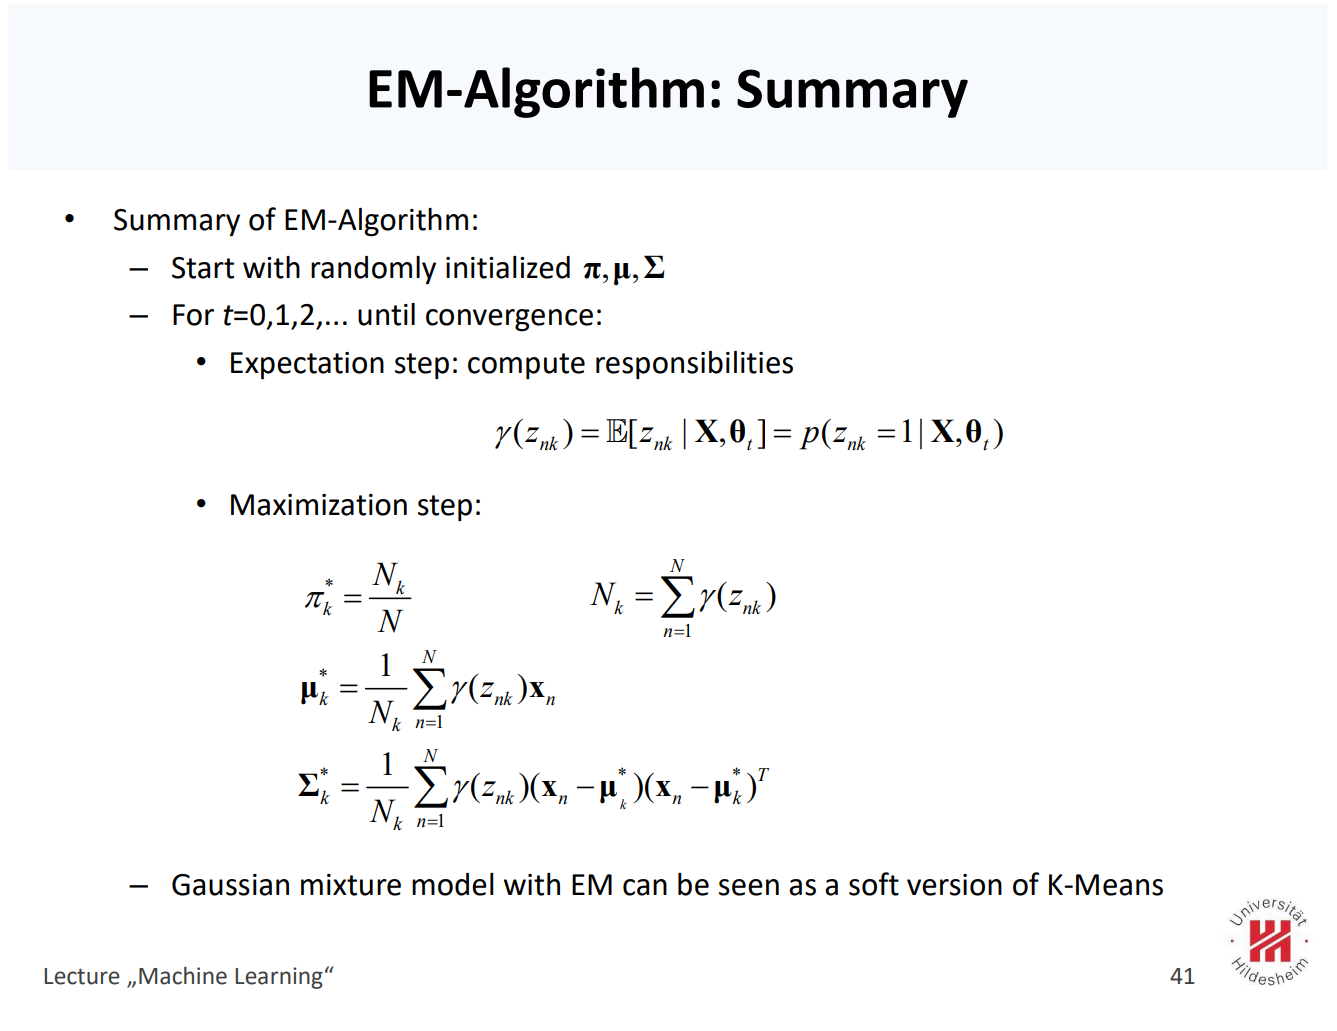


- Initialize clusters by drawing randomly from a uniform distribution.
- Clearly specify the Expectation step and the Maximization step.

In [45]:
### Write your code here

class GMModel:
    def __init__ (self, tol=0.09, mode='soft', max_iter=30):
        self.tol = tol #tolerance to break out of loop
        self.mode = mode #to determine whether to perform soft or hard clustering
        self.max_iter = max_iter
        
    def fit(self, X, num_components):
        #to get the features and observations from the data
        num_obs,m = X.shape
        #to store num_components in class variable
        self.nc = num_components

        #initially the qn are sampled from a uniform normal distribution
        qn_ = np.random.uniform(size=(num_obs,num_components)) #the size will be n x k
        
        #to get weights per example between 0 and 1 we will normalize
        if self.mode == 'soft':
            qn = qn_/qn_.sum(axis=1).reshape(-1,1)
        
        #for hard clustering we will assign points to the cluster with the highest responsibility
        else:
            qn  = np.zeros(shape=(num_obs,num_components))
            qn[np.arange(num_obs),np.argmax(qn_,axis=1)] = 1
        
        #now we will keep iterating until the loop breaks itself
        for _ in range(self.max_iter):
            
            #initializing the model parameters
            pi_k = None
            meu_k = np.zeros(shape=(m,num_components))
            sigma_k = np.zeros(shape=(num_components,m,m))
            
            #### Maximization Step #####
            for k in range(num_components): #iterate over all the clusters
                #first we need to find the value of pi_k
                pi_k = qn.sum(axis=0)/num_obs
                
                #then we need means of the distribution (we will vectorize this operation for efficiency)
                meu_k[:,k] = ((X.T @ qn[:,k].reshape(-1,1))/np.sum(qn[:,k])).reshape(-1)
                
                #finally we need to calculate the variance of the distribution
                add = np.zeros(shape=(m,m))
                
                #iterate over all observations
                for n,x in enumerate(X):
                    x = x.reshape(-1,1)
                    add += (qn[n,k]* (x@x.T)) #this calculate the numerator
                
                #to calculate the variance of the gaussians
                sigma_k[k] = add/np.sum(qn[:,k]) - meu_k[:,[k]]@meu_k[:,[k]].T
                
            #### Expectation Step #####
            qn_ = np.zeros(shape=(num_obs,num_components)) #initialize the empty cluster
            for k in range(num_components): #to iterate over all clusters
                for n,x in enumerate(X): #iterate over each observation
                    
                    #calculate the probability of the sample belonging to particular gaussian
                    dist = multivariate_normal(meu_k[:,k],sigma_k[k],allow_singular=True)
                    qn_[n,k] = dist.pdf(x)
                      
            #for soft clustering we will not only focus on the maximum probability
            if self.mode == 'soft':
                qn_new = qn_/qn_.sum(axis=1).reshape(-1,1)
            
            #for hard clustering we will assign points to the cluster with the highest responsibility
            else:
                qn_new  = np.zeros(shape=(num_obs,num_components))
                qn_new[np.arange(num_obs),np.argmax(qn_,axis=1)] = 1
                
            #stopping criteria
            if np.linalg.norm(qn_new - qn) < self.tol:
                break
            
            #replace the old q with new one for next iteration
            qn = qn_new
        
        #store the model parameters in class variable
        self.meu_k = meu_k
        self.sigma_k = sigma_k
        self.pi_k = pi_k
        self.q = qn_new

    def calculate_distortion(self, X, k, qn, means, covariances):
        #the negative log-likelihood is considered as distortion in case of Gaussian Mixture
        nll = 0
        num_obs, m = X.shape #get the shape of data
        
        for i in range(num_obs): #iterate over each example
            log_likelihood = 0 #to accumulate the log-likelihood
            
            for j in range(k): #iterate over each cluster/gaussian
                #calculate the probability of belonging to particular gaussian
                log_likelihood += qn[i,j] * multivariate_normal.pdf(X[i,:], mean=means[:,j], cov=covariances[j], allow_singular=True)
            
            #get the neg-log-likelihood
            nll -= np.log(log_likelihood)
        return nll / num_obs
    
    def plot_elbow(self, X, max_k=6):
        distort_lst = [] #to store distortion at each number of cluster
        for k in range(1,max_k+1): #iterate over multiple value of K
            self.fit(X,k) #train the model
            
            #get the distortion of the model
            distort_lst.append(self.calculate_distortion(X,k,self.q,self.meu_k,self.sigma_k))
        
        #plotting the plot of K vs distortion
        plt.plot(np.arange(1, max_k +1),distort_lst) #plot the num cluster against distortion
        plt.title('Best Number of Cluster for initialization')
        plt.xlabel('Number of clusters')
        plt.ylabel('Distortion')
        plt.show()        
        
    
    def predict(self, X):
        num_obs, m = X.shape #to get the shape of data
        qn_ = np.zeros(shape=(num_obs,self.nc)) #initialize the empty array
        
        for k in range(self.nc): #iterate over each cluster
            for n,x in enumerate(X): #iterate over each observation
                dist = multivariate_normal(self.meu_k[:,k],self.sigma_k[k], allow_singular=True)
                qn_[n,k] = dist.pdf(x)
        
        #normalize it
        qn_new = qn_/qn_.sum(axis=1).reshape(-1,1)
        return qn_new

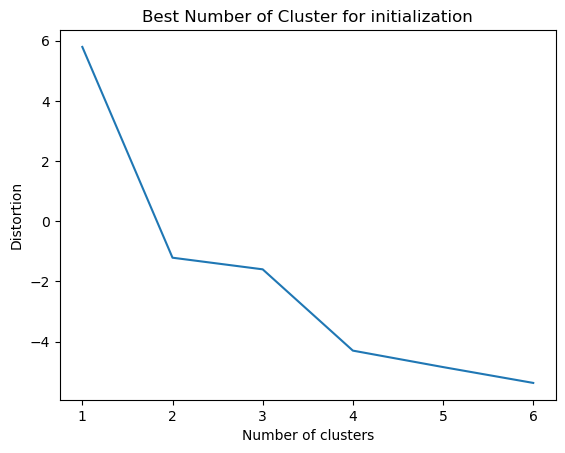

In [46]:
#Plot, a figure showing the selection of the best number of clusters K
#To save time let's only take first 1000 samples
gmm = GMModel()
gmm.plot_elbow(X[:1000,:])

From the plot, 4 looks like a good choice of cluster

**Visualization**

- Use (PCA) to reduce the dimensionality of the data and represent the clusters (GMM) as both 2D and 3D visualizations. 

*In case you did not implement this in the first question, you can use sklearn implementation of PCA for this.*

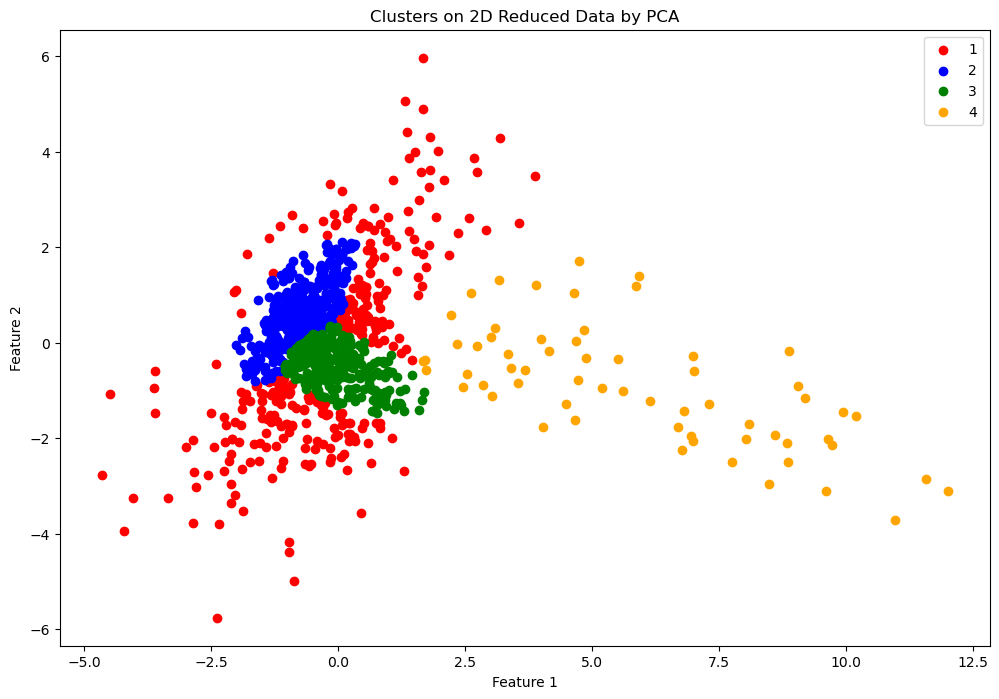

In [69]:
### Write your code here

#Use Hard clustering and 2D visualization
#To save time we have only considered 1000 rows
pca_sklearn = PCA(n_components=2).fit_transform(X[:1000, :])

# Fit Gaussian Mixture Model on the PCA-transformed data
Gmm = GMModel(mode='hard')
Gmm.fit(pca_sklearn,num_components=4)
labels = Gmm.predict(pca_sklearn)

# To plot clusters
fig, ax = plt.subplots(figsize=(12, 8))  # Used plt.subplots() to get both figure and axes
classes = ['1', '2', '3', '4']
colors = ListedColormap(['r', 'b', 'g', 'orange'])

for i in range(len(classes)):
    indices = np.argmax(labels,axis=1) == i
    ax.scatter(pca_sklearn[indices, 0], pca_sklearn[indices, 1], c=colors(i), label=classes[i])  # Removed unnecessary third dimension

ax.legend()
ax.set_title('Clusters on 2D Reduced Data by PCA')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
plt.show()

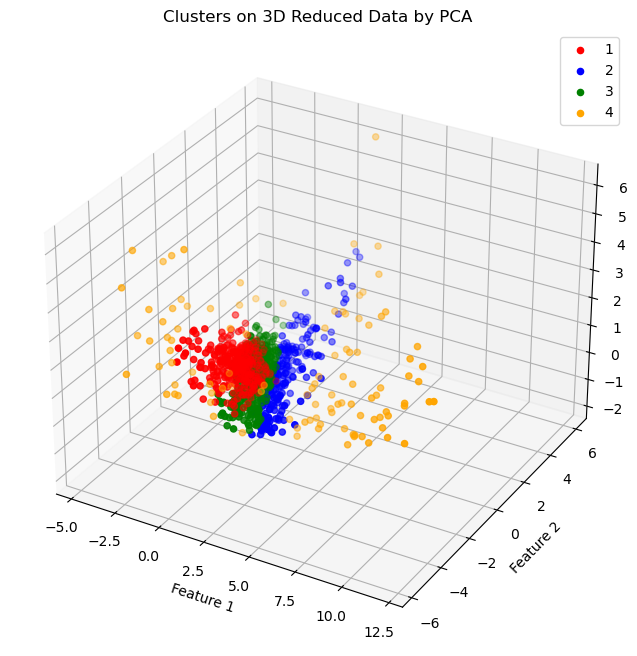

In [64]:
# 3D Plot
pca_sklearn = PCA(n_components=3).fit_transform(X[:1000, :])

# Fit Gaussian Mixture Model on the PCA-transformed data
Gmm = GMModel(mode='hard')
Gmm.fit(pca_sklearn,num_components=4)
labels = Gmm.predict(pca_sklearn)

# To plot clusters in 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

classes = ['1', '2', '3', '4']
colors = ['r', 'b', 'g', 'orange']

for i in range(len(classes)):
    indices = np.argmax(labels,axis=1) == i
    ax.scatter(pca_sklearn[indices, 0], pca_sklearn[indices, 1], pca_sklearn[indices, 2], c=colors[i], label=classes[i])

ax.legend()
ax.set_title('Clusters on 3D Reduced Data by PCA')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')

plt.show()